In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import googlemaps
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import googlemaps
import folium
from folium import plugins
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from sklearn import preprocessing

In [69]:
# hidden_cell
gmaps = googlemaps.Client(key='AIzaSxxxxxxxxxxxxxxxUZPTo')

https://www.daft.ie/dublin-city/commercial-property-for-sale/?ad_type=commercial&advanced=1&s%5Ba_id%5D%5B0%5D=pc1&searchSource=commercial

### <a id="data_ac">Data Acquisition</a>

In [2]:
commercials = pd.DataFrame(columns=['Name', 'Commercial Type', 'Price', 'sq metres', 'Neighbourhood'])

In [3]:
districts = list(range(1,14))
pages = [0, 20, 40, 60]
for district in districts:
    for page in pages:
        url = 'https://www.daft.ie/dublin-city/commercial-property-for-sale/?ad_type=commercial&advanced=1&s%5Ba_id%5D%5B0%5D=pc{}&searchSource=commercial&offset={}'.format (district, page)
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
        source = requests.get(url, headers=headers).text
        soup = BeautifulSoup(source, 'lxml')
        amusements_soup = BeautifulSoup(source,"html.parser")

        commercials_D1 = pd.DataFrame(columns=['Name', 'Commercial Type', 'Price', 'sq metres', 'Neighbourhood'])
        i=0
        for item in amusements_soup.findAll('div',{'class':'box'}):
            sub_items = item.findAll('a') 
            for sub_item in sub_items:
                sub_text = sub_item.text.strip().split(' - ')
                sub_text2 = sub_text[0].strip()
                commercials_D1.loc[i, 'Name'] = sub_text2
                sub_text3 = sub_text2.split(',')
                commercials_D1.loc[i, 'Neighbourhood'] = sub_text3[-1].strip()
                i+=1
                break
        i=0        
        for item in amusements_soup.findAll('ul',{'class':'info'}):
            sub_items = item.findAll('li')
            sub_text = sub_items[0].text.strip().split('|')
            commercials_D1.loc[i, 'Commercial Type'] = sub_text[0].strip()
            i+=1

        i=0
        for item in amusements_soup.findAll('strong',{'class':'price'}):
            try:
                sub_text = item.text.strip().split()
                sub_text2 = sub_text[0].strip()
                sub_text3 = sub_text2.replace('€', '')
                sub_text3 = sub_text3.replace(',', '')
                sub_text3 = sub_text3.replace('Price', '')
                commercials_D1.loc[i, 'Price'] = int(sub_text3)
                i+=1
            except:
                i+=1
                continue
        i=0
        for item in amusements_soup.findAll('ul',{'class':'info'}):
            sub_items = item.findAll('li')
            try:
                sub_text = sub_items[1].text.strip().split('(')       
                sub_text2 = sub_text[1].strip().split(' sq.')
                sub_text3 = sub_text2[0].strip().replace(',', '')
                if sub_text3[0] == '0':
                    sub_text3 = ''
                commercials_D1.loc[i, 'sq metres'] = int(sub_text3)
                i+=1
            except:
                i+=1
                continue

        commercials = commercials.append(commercials_D1)

In [7]:
#commercials.to_csv('Features_csv/commercials_web.csv', index=False)

In [4]:
commercials.head()

,Name,Commercial Type,Price,sq metres,Neighbourhood
0,"11/11A Ormond Quay Lower, Dublin 1",Office To Let or For Sale,1300000,465,Dublin 1
1,"21 Ormond Quay Upper, Dublin 1",Restaurant / Bar / Hotel For Sale,2250000,570,Dublin 1
2,"32 Lower Ormond Quay, Dublin 1, Dublin 1",Investment Property For Sale,700000,314,Dublin 1
3,"308 The Capel Building, Mary Street, Dublin 1",Office For Sale,180000,NaN,Dublin 1
4,"Independent House, Talbot Street, Dublin 1",Investment Property For Sale,29000000,NaN,Dublin 1


In [5]:
commercials.isna().sum()

Name                 0
Commercial Type      0
Price              118
sq metres           64
Neighbourhood        0
dtype: int64

In [6]:
commercials.shape

(333, 5)

In [7]:
commercials_clean = commercials.dropna(how='any')

In [8]:
commercials_clean.shape

(174, 5)

In [9]:
dub_commercials_clean = commercials_clean[commercials_clean['Neighbourhood'].astype(str).str.contains('Dublin')].copy()
print ('Dataset has {} commercials'.format (dub_commercials_clean.shape[0]))

Dataset has 173 commercials


In [10]:
dub_commercials_clean_int = dub_commercials_clean.copy()

In [11]:
dub_commercials_clean_int[['Price', 'sq metres']] = dub_commercials_clean_int[['Price', 'sq metres']].apply(pd.to_numeric)

In [12]:
dub_commercials_clean_int.dtypes

Name               object
Commercial Type    object
Price               int64
sq metres           int64
Neighbourhood      object
dtype: object

### <center><a href="./b.Liffey.ipynb#data_ac">NEXT CHAPTER</a></center>

#### <center> <a href="./../0.Table_of_Contents_Code.ipynb">Table of Contents</a><br></center>

### <a id="feat_gen">Feature Generation</a>

Price per square meter

In [13]:
dub_commercials_clean_int['Price per sq metres'] = dub_commercials_clean_int['Price']/dub_commercials_clean_int['sq metres']
dub_commercials_clean_int['Price per sq metres'] = dub_commercials_clean_int['Price per sq metres'].round(2)

In [14]:
dub_commercials_clean_int.head(2)

,Name,Commercial Type,Price,sq metres,Neighbourhood,Price per sq metres
0,"11/11A Ormond Quay Lower, Dublin 1",Office To Let or For Sale,1300000,465,Dublin 1,2795.70
1,"21 Ormond Quay Upper, Dublin 1",Restaurant / Bar / Hotel For Sale,2250000,570,Dublin 1,3947.37


In [15]:
dub_commercials_clean_int.describe()

,Price,sq metres,Price per sq metres
count,1.730000e+02,173.000000,173.000000
mean,1.373641e+06,585.901734,5624.466243
std,2.076866e+06,1206.434887,26487.273172
min,1.000000e+00,4.000000,0.010000
25%,3.950000e+05,154.000000,1325.300000
50%,6.500000e+05,254.000000,3232.760000
75%,1.400000e+06,546.000000,4828.800000
max,1.500000e+07,13152.000000,350000.000000


Grouping rows by neighborhood and by taking the mean

In [16]:
dub_commercials_clean_int_grouped = dub_commercials_clean_int.groupby('Neighbourhood').mean().reset_index()
dub_commercials_clean_int_grouped

,Neighbourhood,Price,sq metres,Price per sq metres
0,Dublin 1,1.233929e+06,364.142857,17152.212500
1,Dublin 10,2.375000e+06,2613.000000,1733.895000
2,Dublin 11,6.515385e+05,726.615385,2092.941538
3,Dublin 12,7.605952e+05,932.023810,1293.922619
4,Dublin 2,2.946458e+06,506.000000,5930.527083
5,Dublin 3,4.880000e+05,191.000000,2765.600000
6,Dublin 4,2.197222e+06,484.444444,5142.671111
7,Dublin 5,8.250000e+05,193.600000,3711.502000
8,Dublin 6,2.620000e+06,1083.200000,4266.988000
9,Dublin 6w,9.125000e+05,318.500000,2806.250000


In [40]:
dub_commercials_clean_int.to_csv('Features_csv/dub_commercials_clean_int_mod1.csv', index=False)

In [5]:
dub_commercials_clean_int = pd.read_csv('Features_csv/dub_commercials_clean_int_mod1.csv')

(0, 176600646.97525626)

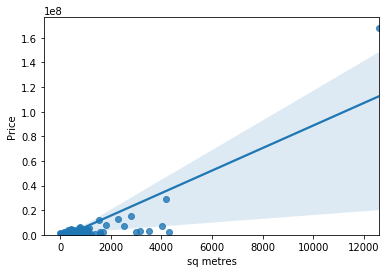

In [18]:
sns.regplot(x = 'sq metres',  y= 'Price', data = dub_commercials_clean_int)
plt.ylim(0,)

There's a clear outlier

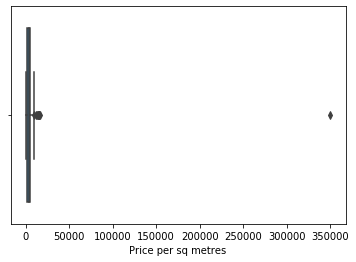

In [20]:
sns.boxplot(x=dub_commercials_clean_int['Price per sq metres'])

In [21]:
dub_commercials_clean_int['Price per sq metres'].max()

350000.0

In [6]:
dub_c = dub_commercials_clean_int.copy()

In [7]:
dub_c.reset_index(drop=True, inplace=True)

Finding the outlier index

In [24]:
dub_c[dub_c['Price per sq metres'] == dub_c['Price per sq metres'].max()]

,Name,Commercial Type,Price,sq metres,Neighbourhood,Price per sq metres
5,"31 Liffey Street Upper, Dublin 1",Investment Property For Sale,1400000.0,4.0,Dublin 1,350000.0


Having a look of the others commercials, this seems to be a typo. After checking the data source, the sq. metres is corrected from 4 to 163

In [8]:
dub_c.loc[5,'sq metres'] = 163

In [26]:
dub_c.iloc[5,:]

Name                   31 Liffey Street Upper, Dublin 1
Commercial Type            Investment Property For Sale
Price                                           1.4e+06
sq metres                                           163
Neighbourhood                                  Dublin 1
Price per sq metres                              350000
Name: 5, dtype: object

Now we need to recalculate 'Price per sq metres' column

In [9]:
dub_c.drop(columns=['Price per sq metres'], inplace=True)
dub_c['Price per sq metres'] = dub_c['Price']/dub_c['sq metres']
dub_c['Price per sq metres'] = dub_c['Price per sq metres'].round(2)

(0, 176595317.28082404)

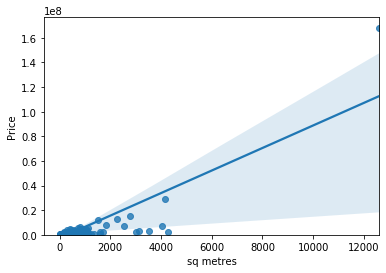

In [28]:
sns.regplot(x = 'sq metres',  y= 'Price', data = dub_c)
plt.ylim(0,)

We've got another outlier. Let's have a closer look

In [29]:
dub_c[dub_c['sq metres'] == dub_c['sq metres'].max()]

,Name,Commercial Type,Price,sq metres,Neighbourhood,Price per sq metres
49,"Fitzwilliam 28, Fitzwilliam Street Lower, Dubl...",Investment Property For Sale,168000000.0,12599.0,Dublin 2,13334.39


Data is correct. It's an Industrial Site with a huge area. Removed from the dataset due to this type of commercial is not relevant for this project 

In [10]:
dub_c.drop(dub_c.index[49], inplace=True)

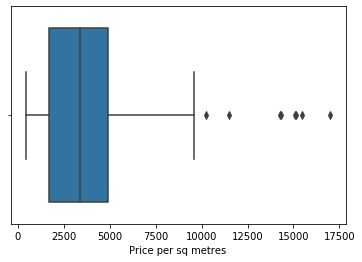

In [31]:
sns.boxplot(x=dub_c['Price per sq metres'])

In [32]:
dub_c[['sq metres', 'Price']].corr()

,sq metres,Price
sq metres,1.000000,0.661345
Price,0.661345,1.000000


In [33]:
dub_c.sort_values(by=['Price per sq metres'], ascending=False).head(6)

,Name,Commercial Type,Price,sq metres,Neighbourhood,Price per sq metres
6,"34 Liffey Street Lower, Dublin 1",Retail Unit For Sale,850000.0,50.0,Dublin 1,17000.00
7,"32 Liffey Street Lower, Dublin 1",Retail Unit For Sale,850000.0,55.0,Dublin 1,15454.55
131,"80 Thomas Street, Dublin 8",Commercial Site For Sale,650000.0,43.0,Dublin 8,15116.28
50,"33-34 Essex Street, Temple Bar, Dublin 2, Dubl...",Investment Property For Sale,2500000.0,166.0,Dublin 2,15060.24
47,"4 St Stephen's Green, Dublin 2",Investment Property For Sale,4250000.0,297.0,Dublin 2,14309.76
53,"Dame Street, Dublin 2",Restaurant / Bar / Hotel For Sale,500000.0,35.0,Dublin 2,14285.71


In [37]:
dub_c.sort_values(by=['Price per sq metres']).head()

,Name,Commercial Type,Price,sq metres,Neighbourhood,Price per sq metres
137,"Units 26, 42 & 43 Cherry Orchard Industrial Es...",Industrial Unit To Let or For Sale,1950000.0,4297.0,Dublin 10,453.80
182,"3 Ballymount Cottages, Turnpike road, Ballymou...",Commercial Site For Sale,595000.0,1100.0,Dublin 12,540.91
141,"Unit 94B Lagan Road, Dublin Industrial Estate,...",Industrial Unit For Sale,380000.0,641.0,Dublin 11,592.82
184,122a Cromwellsfort Road and 2 Cherry Grove Roa...,Commercial Site For Sale,850000.0,1376.0,Dublin 12,617.73
163,"Centro House, Bluebell Avenue, Bluebell Indust...",Industrial Unit For Sale,995000.0,1596.0,Dublin 12,623.43


Removing the outlier

In [11]:
dub_c.drop(dub_c.index[67], inplace=True)

Reindexing the dataframe

In [12]:
dub_c.reset_index(drop=True, inplace=True)

In [40]:
dub_c.head(2)

,Name,Commercial Type,Price,sq metres,Neighbourhood,Price per sq metres
0,"Cleary's Bar, Lounge & Adjacent Barbers Shop, ...",Restaurant / Bar / Hotel For Sale,1500000.0,301.0,Dublin 1,4983.39
1,"21 Ormond Quay Upper, Dublin 1",Restaurant / Bar / Hotel For Sale,2250000.0,570.0,Dublin 1,3947.37


In [41]:
dub_c.sort_values(by=['Price per sq metres']).head(2)

,Name,Commercial Type,Price,sq metres,Neighbourhood,Price per sq metres
135,"Units 26, 42 & 43 Cherry Orchard Industrial Es...",Industrial Unit To Let or For Sale,1950000.0,4297.0,Dublin 10,453.80
180,"3 Ballymount Cottages, Turnpike road, Ballymou...",Commercial Site For Sale,595000.0,1100.0,Dublin 12,540.91


Grouping rows in order to visualize the Distribution Price per sq. metre by Districts using Matplotlib

In [13]:
dub_c_grouped = dub_c.groupby('Neighbourhood').mean().reset_index()
dub_c_grouped = dub_c_grouped.round(2)
dub_c_grouped.sort_values(by=['Price per sq metres'], ascending=False, inplace=True)
dub_c_grouped.drop(columns=['Price', 'sq metres'], inplace=True)
dub_c_grouped.set_index('Neighbourhood', inplace=True)

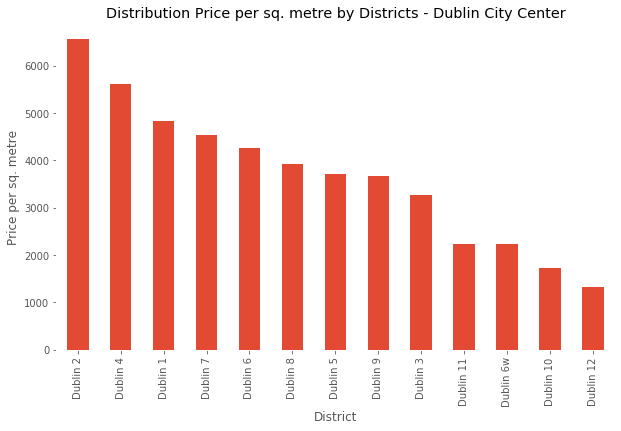

In [43]:
plt.style.use('ggplot') # optional: for ggplot-like style
ax = dub_c_grouped.plot(kind='bar', figsize=(10, 6))
ax.set_facecolor('white') # remove background
ax.get_legend().remove() # remove legend
plt.xlabel('District') # add to x-label to the plot
plt.ylabel('Price per sq. metre') # add y-label to the plot
plt.title('Distribution Price per sq. metre by Districts - Dublin City Center') # add title to the plot

plt.show()

In [44]:
dub_c_grouped

,Price per sq metres
Neighbourhood,
Dublin 2,6560.94
Dublin 4,5606.02
Dublin 1,4820.62
Dublin 7,4531.15
Dublin 6,4266.99
Dublin 8,3917.16
Dublin 5,3711.50
Dublin 9,3674.16
Dublin 3,3261.93


In [45]:
dub_c.shape

(191, 6)

Adding coordinates to represent data on map

In [46]:
def getCoordinates(names):
    
    Coordinates_list=[]
    for name in zip(names):
        space = '     '
        print(name[0] +'{}'.format(10*space), end="\r", flush=True)
        query = gmaps.geocode(name)

        Coordinates_list.append([(
            name[0],
            v['geometry']['location']['lat'], 
            v['geometry']['location']['lng']) for v in query])

    Coordinates = pd.DataFrame([item for Coordinate_list in Coordinates_list for item in Coordinate_list])
    Coordinates.columns = ['Name',
                  'Latitude', 
                  'Longitude']

    return(Coordinates)

In [71]:
dub_c_coordinates = getCoordinates(names = dub_c['Name'])

Finding some duplicates due to Gmap API drop a couple of coordinates on some locations

In [86]:
print ('There\'re {} duplicates rows'.format (dub_c_coordinates['Name'].duplicated().sum()))

There're 46 duplicates rows


In [2]:
dub_c_coordinates = pd.read_csv('Features_csv/duc_c_coordinates_new_t.csv')

In [3]:
dub_c_coor_clean = dub_c_coordinates.drop_duplicates(['Name'], keep='first')

Checking all rows are unique

In [51]:
dub_c_coor_clean['Name'].is_unique

True

#### dub_c_coordinates.to_csv('dub_c_coordinates_new_mod.csv', index=False)

In [52]:
dub_c_coor_clean.shape

(187, 3)

In [14]:
dub_c = dub_c.drop_duplicates(['Name'], keep='first')

In [54]:
dub_c.shape

(186, 6)

Merging dataframes in order to keep the rest of the columns

In [15]:
dub_result = pd.merge(dub_c, dub_c_coor_clean, how='left', on=['Name'])

In [56]:
dub_result.head(2)

,Name,Commercial Type,Price,sq metres,Neighbourhood,Price per sq metres,Latitude,Longitude
0,"Cleary's Bar, Lounge & Adjacent Barbers Shop, ...",Restaurant / Bar / Hotel For Sale,1500000.0,301.0,Dublin 1,4983.39,53.352145,-6.249610
1,"21 Ormond Quay Upper, Dublin 1",Restaurant / Bar / Hotel For Sale,2250000.0,570.0,Dublin 1,3947.37,53.345893,-6.270229


Creating an array with 'Latitude', 'Longitude', 'Price per sq metres' columns in order to input to the HeatMap

In [16]:
dub_data = dub_result[['Latitude', 'Longitude', 'Price per sq metres']].values

Representation of the areas with higher price per sq. metre in Dublin City

In [17]:
max_price = float(dub_result['Price per sq metres'].max())
dub_latitude = '53.341785'
dub_longitude = '-6.265288'
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dub_latitude, dub_longitude], zoom_start=14)

HeatMap(list(zip(dub_result.Latitude.values, dub_result.Longitude.values, dub_result['Price per sq metres'].values)), 
        radius = 50, blur=50, max_val=max_price).add_to(folium.FeatureGroup(name='Heat Map').add_to(map_dublin))
folium.LayerControl().add_to(map_dublin)
    
map_dublin

As we can see, there are spots with no data, so in order to have a more consistent price on the map:

Mesh points created to set the scope boundaries for this project will be used.
- Getting the correspondent District for each point of the mesh
- Assigning the median value obtained from the Groupby Districts which has been calculated
- Adding this new data to the HeatMap

In [21]:
dub_mesh = pd.read_csv('Features_csv/Dublin_mesh_76.csv')

In [60]:
dub_mesh.head(1)

,Unnamed: 0,Latitude,Longitude,Coordinates,District,PostCode
0,0,53.322556,-6.287982,"53.322556, -6.287982",Kimmage C ED,Dublin 6


In [22]:
dub_mesh_clean = dub_mesh[['Latitude', 'Longitude', 'PostCode']].copy()
dub_mesh_clean.head(2)

,Latitude,Longitude,PostCode
0,53.322556,-6.287982,Dublin 6
1,53.322556,-6.280417,Dublin 6


Using Groupby data

In [63]:
dub_c_grouped.head()

,Price per sq metres
Neighbourhood,
Dublin 2,6560.94
Dublin 4,5606.02
Dublin 1,4820.62
Dublin 7,4531.15
Dublin 6,4266.99


In [163]:
# dub_c_grouped.to_csv('Dublin_median_price_by_Districts.csv')

In [ ]:
i=0
for i in range(0, len(dub_mesh_clean)):
    dub_mesh_clean.loc[i, 'Price per sq metres'] = dub_c_grouped.loc[dub_mesh_clean.loc[i, 'PostCode'], 'Price per sq metres']

In [67]:
dub_mesh_clean.sample(5)

,Latitude,Longitude,PostCode,Price per sq metres
55,53.346592,-6.242594,Dublin 2,6560.94
3,53.322556,-6.265288,Dublin 6,4266.99
18,53.332171,-6.295547,Dublin 12,1315.25
4,53.322556,-6.257723,Dublin 6,4266.99
64,53.351400,-6.250158,Dublin 1,4820.62


In [26]:
dub_mesh_clean.drop(columns=['PostCode'], inplace=True)

Merging previous commercials' data with new mesh points dataframe 

In [19]:
dub_result_data = dub_result[['Latitude', 'Longitude', 'Price per sq metres']].copy()
print (dub_result_data.head())
print ('Commercials\' data: {} rows'.format (dub_result_data.shape[0]))


    Latitude  Longitude  Price per sq metres
0  53.352145  -6.249610              4983.39
1  53.345893  -6.270229              3947.37
2  53.346655  -6.269338              4736.84
3  53.351250  -6.252907              6949.44
4  53.357633  -6.263205              1444.72
Commercials' data: 186 rows


In [23]:
dub_data_df = dub_result_data.append(dub_mesh_clean)
dub_data_df.reset_index(drop=True, inplace=True)
print ('New data merged: {} rows'.format (dub_data_df.shape[0]))

New data merged: 262 rows


In [24]:
dub_data_merged = dub_data_df[['Latitude', 'Longitude', 'Price per sq metres']].values

In [ ]:
max_price = float(dub_data_df['Price per sq metres'].max())
dub_latitude = '53.341785'
dub_longitude = '-6.265288'
# create map of Dublin using latitude and longitude values
map_dublin = folium.Map(location=[dub_latitude, dub_longitude], zoom_start=14)
# add markers to map
HeatMap(list(zip(dub_data_df.Latitude.values, dub_data_df.Longitude.values, dub_data_df['Price per sq metres'].values)), 
        radius = 50, blur=50, max_val=max_price).add_to(folium.FeatureGroup(name='Heat Map').add_to(map_dublin))
folium.LayerControl().add_to(map_dublin)
    
map_dublin

In [73]:
dub_mesh_clean.sample(3)

,Latitude,Longitude,Price per sq metres
40,53.341785,-6.280417,3917.16
60,53.351400,-6.280417,4531.15
8,53.327363,-6.295547,1315.25


Normalizing the grouped data by districts and modifying values in order increase the differencial between districts for visual purposes

In [74]:
dub_grouped_nor = dub_c_grouped.copy()

In [75]:
dub_grouped_nor['Price per sq metres'] = dub_grouped_nor['Price per sq metres']/dub_grouped_nor['Price per sq metres'].min()

In [76]:
dub_grouped_nor.head()

,Price per sq metres
Neighbourhood,
Dublin 2,4.988360
Dublin 4,4.262323
Dublin 1,3.665174
Dublin 7,3.445086
Dublin 6,3.244243


In [77]:
dub_grouped_nor.to_csv('Features_csv/Dublin_median_price_by_Districts_NOR.csv')

### <center><a href="./../C.Feature%20Selection.ipynb#code0">NEXT CHAPTER</a></center>

#### <center> <a href="./../0.Table_of_Contents_Code.ipynb">Table of Contents</a><br></center>